**Exercise 10 - Transfer Learning**

---

In this exercise you will work with transfer learning on image classification. In this task you will use the ResNet to classify images, however, differently from the other tasks, you will not use a huge dataset, but a small "handmade" dataset. In the exercise directory you have a *data* directory with some pictures taken with a smartphone, you can use it or if you prefer, use your own cellphone to take your own pictures. Since you will have to label it, there will no advantage of using this or your data. Your task will be, first, define the classes and label the images, then, build the model to classify those images, and last, use the pretrained ResNet weights and compare the results.

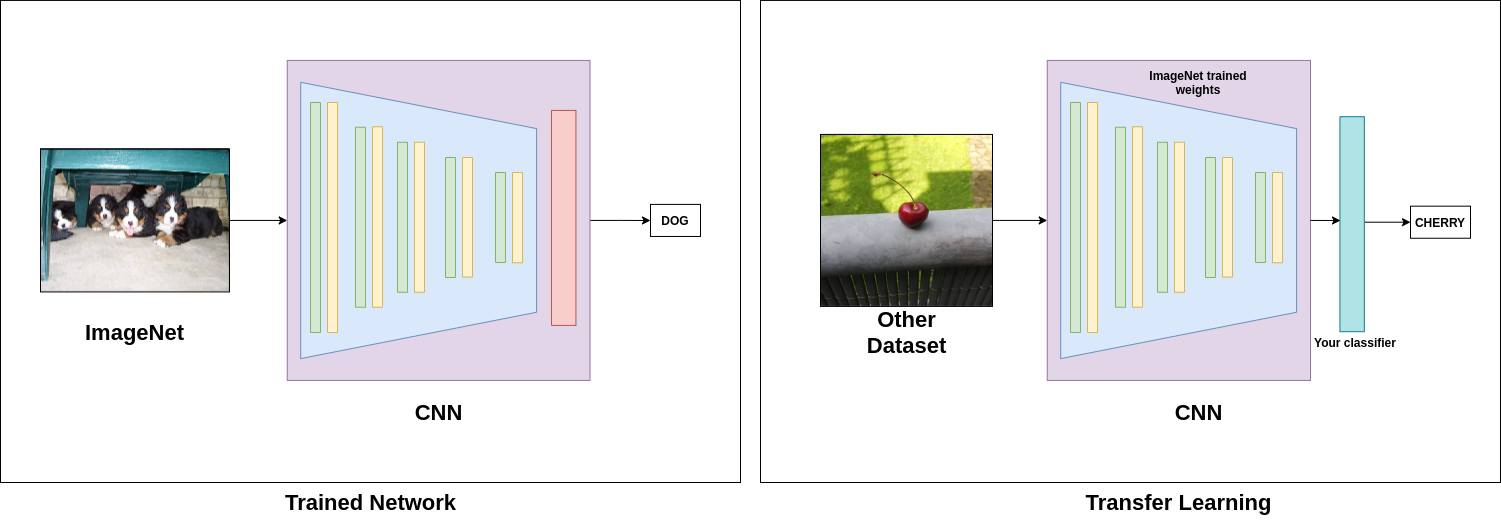

In [1]:
from IPython.display import Image
Image('mlrcv/notebook_images/transferlearn.png')

**10.1 Labeling data \[3\]**

---

Given the selected dataset (the images provided, or the one that you have collected) you should label it. Inside the *data* directory there are two other directories *train_img* and *val_img* with the train and validation images. If you collect your own data you should mantain these directories structure. After defining the data that you will work with, you can start labeling it.

First you need to check and define the classes present on dataset, this definition should be mapped on the *class_to_lbl* dictionary inside the file *mlrcv/data_map.py*. The mapping should be on the format:

```
class_to_lbl = {
    0: "dog",
    1: "cat",
    ...
}
```

Then, you should fill the other two dictionary inside *mlrcv/data_map.py*, *train_annotation* and *val_annotation*, with the image-wise annotation, giving to each image a unique label. Following the format:

```
train_annotation = {
    "xxxx.jpg": 6,
    "xxxy.jpg": 0,
    ...
}

val_annotation = {
    "zzzz.jpg": 0,
    "zzzw.jpg": 4,
    ...
}
```

After filling the dictionaries you check if it's correctly mapped by running the cell below:

In [2]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt
from mlrcv.data_map import class_to_lbl, train_annotation, val_annotation
from mlrcv.dataloader import ImageLoader, transform_train, transform_val
from mlrcv.trainer import ClassificationTrainer, freeze_net_params
from mlrcv.model_loader import build_classifier
from PIL import Image
%load_ext autoreload
%autoreload 2

# !mkdir train_logs
# !mkdir checkpoint

After generating the annotation and class dictionaries, by running the cell above you should see one random image from train dataset with it's label written on the $x$ axis, so you can check if your annotations are correctly mapped.

**10.2 Bulding the dataloader \[3\]**

---

After labelling the data you should load it properly to use it on pytorch. Your next task is to implement the *DataLoader*, torchvision provides many datasets DataLoaders already implemented, but usually it's necessary to implement your own DataLoader to deal with your data and task specifications. You should implement the *load_images* function from *ImageLoader* class inside *mlrcv/dataloader.py*. You should load the image data and it's annotation, create a dictionary with:

```
{
    "img": Image, #PIL Image
    "label": label, #label as int
}
```

Then, append it to the *images_annotation* list class attribute.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


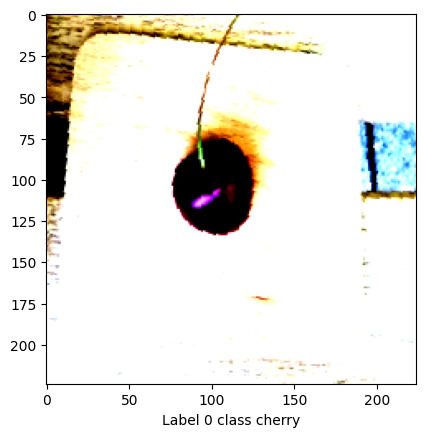

In [3]:
test_data = ImageLoader('./data/train_img', train_annotation, transform=transform_train)
#test_data = ImageLoader('./data/train_img', train_annotation)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, num_workers=4)

test_iter = iter(test_loader)
#data = test_iter.next()
data = next(test_iter)

img = data['img'][0].permute(1,2,0)
plt.imshow(img)
plt.xlabel(f'Label {data["label"].item()} class {class_to_lbl[data["label"].item()]}')
plt.show()

As before, if everything works you should see above an image from the dataset with it's label and class on $x$ axis.

**10.3 Bulding the model \[3\]**

---

The ResNet model can be used directly from the *torchvision* implementation, however, in their implementation the network is built for the ImageNet dataset, which means that the last layer outputs 1000 values, which is the number of classes on ImageNet dataset. To use it on a different dataset you should remove the last layer and append to it your own final layers (see figure 1). In this task you should implement the function *build_resnet_model* to build the model to classify the dataset that you have labeled.


In [4]:
resnet = models.resnet18()


In [5]:
num_ftrs = resnet.fc.in_features
num_ftrs

512

In [6]:
resnet.fc

Linear(in_features=512, out_features=1000, bias=True)

In [7]:
num_class = 13

resnet = models.resnet18()
# the resnet output has shape [batch_size, 512]

# overwrite the classifier
resnet.fc = build_classifier(num_class=13)
output = resnet(data['img'])

assert output.shape[-1] == num_class,\
    f"[num_class({num_class}) != out_feats({output.shape[-1]})]: output features num should be equal to the num_class"

print(resnet.fc)


Sequential(
  (0): Linear(in_features=512, out_features=13, bias=True)
)


You should see above the classifier that you have built with the layers and features sizes that you defined.

Before start the training, start tensorboard. The logs will be saved in the center_logs/, so you can start tensorboard inside the notebook, or through terminal by running tensorboard --logdir=center_logs which then can be visualized on the browser acessing localhost:6006.

In [8]:
# setup tensorboard
%load_ext tensorboard
%tensorboard --logdir train_logs

Then, you can train this network using your data:

In [9]:
train_data = ImageLoader('./data/train_img', train_annotation, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True, num_workers=4)

val_data = ImageLoader('./data/val_img', val_annotation, transform=transform_train)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=num_class, num_workers=4)

lr = 1e-3
epochs = 100

In [10]:
resnet = models.resnet18()
# overwrite the classifier
resnet.fc = build_classifier(num_class=13)

classifier = ClassificationTrainer(resnet, torch.nn.CrossEntropyLoss(), train_loader, val_loader, class_to_lbl, lr, epochs, log_name='no_transfer_learning')
trainer = pl.Trainer(max_epochs=epochs, check_val_every_n_epoch=10)
trainer.fit(classifier)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\shobh\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Missing logger folder: C:\Users\shobh\Downloads\Ex10\assignment\lightning_logs

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 11.2 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.733    Total estimated model params size (MB)


C:\Users\shobh\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\trainer.py:1600: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 9:  88%|████████████████████████████████████████████████▏      | 7/8 [00:17<00:02,  2.47s/it, loss=1.82, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 19:  88%|███████████████████████████████████████████████▎      | 7/8 [00:17<00:02,  2.49s/it, loss=1.31, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 29:  88%|███████████████████████████████████████████████▎      | 7/8 [00:15<00:02,  2.28s/it, loss=1.03, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 39:  88%|██████████████████████████████████████████████▍      | 7/8 [00:16<00:02,  2.38s/it, loss=0.756, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 49:  88%|██████████████████████████████████████████████▍      | 7/8 [00:15<00:02,  2.20s/it, loss=0.717, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 59:  88%|██████████████████████████████████████████████▍      | 7/8 [00:15<00:02,  2.21s/it, loss=0.497, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 69:  88%|██████████████████████████████████████████████▍      | 7/8 [00:15<00:02,  2.16s

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|█████████████████████████████████████████████████████| 8/8 [00:26<00:00,  3.37s/it, loss=0.364, v_num=0]


On tensorboard you can follow the training and check your network performance on this small dataset. It's possible to see an overfitting on the training data, the accuracy increase while the loss decrease, however the accuracy on the validation set is way lower than the training accuracy. Due to the low number of samples the network can't find general representative features to correctly classify the images. You can try changing the classifier the architecture that you have defined on *build_resnet_model* and try to improve it's performance.

**10.4 Transfer learning \[1\]**

---

From the previous task you should have noticed that even with different architectures for the last layers the performance on this small dataset can not be increased significantly, leading to overfit on training data and poor performance on validation data. This is a problem with small datasets, without enough data it's hard for the network to generalize a good solution even for the training data. In this last task you will use transfer learning to improve your model performance.

Alongside the implemented model, *torchvision* also provide the network trained weights. So you can load it, and do the training on your small dataset using the weights learned from a bigger dataset, in this case, ImageNet. The advantage of using the pretrained weights is to start the network training with weights good enough to extract representative features, and then finetune it to the current dataset specific characteristics.

In [11]:
resnet = models.resnet18(pretrained=True)
# overwrite the classifier
resnet.fc = build_classifier(num_class=13)

classifier = ClassificationTrainer(resnet, torch.nn.CrossEntropyLoss(), train_loader, val_loader, class_to_lbl, lr, epochs, log_name='transfer_learning_train_finetune')
trainer = pl.Trainer(max_epochs=epochs, check_val_every_n_epoch=10)
trainer.fit(classifier)

C:\Users\shobh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shobh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\shobh\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not us

Epoch 9:  88%|███████████████████████████████████████████████▎      | 7/8 [00:17<00:02,  2.43s/it, loss=0.475, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 19:  88%|██████████████████████████████████████████████▍      | 7/8 [00:16<00:02,  2.34s/it, loss=0.384, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 29:  88%|███████████████████████████████████████████████▎      | 7/8 [00:15<00:02,  2.14s/it, loss=0.31, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 39:  88%|██████████████████████████████████████████████▍      | 7/8 [00:15<00:02,  2.20s/it, loss=0.177, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 49:  88%|█████████████████████████████████████████████▌      | 7/8 [00:15<00:02,  2.20s/it, loss=0.0757, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 59:  88%|██████████████████████████████████████████████▍      | 7/8 [00:15<00:02,  2.21s/it, loss=0.362, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 69:  88%|██████████████████████████████████████████████▍      | 7/8 [00:15<00:02,  2.19s

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|████████████████████████████████████████████████████| 8/8 [00:38<00:00,  4.87s/it, loss=0.0868, v_num=1]


From the logs of the previous cell you can compare on tensorboard the results from training the network with and without transfer learning. From this comparison it's possible to see that, by using the ImageNet pretrained weights the train and validation accuracy are much higher than when training the network without the pretrained weights. Also, it converge faster to the final solution, since from the beginning the network can already extract representative/general features from the image. However, at some point the performance may start decreasing, this can happen because the network starts losing generalization and starts also to overfit on your data particularities.

Other possibility is to also freeze the pretrained weights, training only the final classifier. We do not update the ImageNet pretrained weights and update only the classifier during training.

In [12]:
resnet = models.resnet18(pretrained=True)
resnet = freeze_net_params(resnet)
# overwrite the classifier
resnet.fc = build_classifier(num_class=13)

classifier = ClassificationTrainer(resnet, torch.nn.CrossEntropyLoss(), train_loader, val_loader, class_to_lbl, lr, epochs, log_name='transfer_learning_train_freezed')
trainer = pl.Trainer(max_epochs=epochs, check_val_every_n_epoch=10)
trainer.fit(classifier)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 11.2 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
6.7 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.733    Total estimated model params size (MB)


Epoch 9:  88%|███████████████████████████████████████████████▎      | 7/8 [00:12<00:01,  1.76s/it, loss=0.911, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 19:  88%|██████████████████████████████████████████████▍      | 7/8 [00:15<00:02,  2.18s/it, loss=0.365, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 29:  88%|███████████████████████████████████████████████▎      | 7/8 [00:13<00:01,  1.91s/it, loss=0.22, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 39:  88%|██████████████████████████████████████████████▍      | 7/8 [00:13<00:01,  1.88s/it, loss=0.156, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 49:  88%|██████████████████████████████████████████████▍      | 7/8 [00:12<00:01,  1.79s/it, loss=0.123, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 59:  88%|██████████████████████████████████████████████▍      | 7/8 [00:12<00:01,  1.81s/it, loss=0.134, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 69:  88%|█████████████████████████████████████████████▌      | 7/8 [00:12<00:01,  1.84s/

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.09s/it, loss=0.0763, v_num=2]


By freezing the pretrained weights it may improve even more the performance of the network (you can compare on tensorboard). With a small dataset, if we update the pretrained weights it may be decrease the performance since this dataset is not representative enough, and this poor dataset can "harm" the network weights making the network lose some generalization and performance.

Using the pretrained network and freezing it's weights brings a better performance, achieving high accuracy on both training and validation sets.

**Assignment Submission**

---

You should zip and submit the ```ex10_transfer_learning.ipynb``` file together with all the ```.py``` files inside the ```mlrcv/``` directory and the `train_logs` directory.

**DO NOT** submit the `data` directory!

You can automatically generate the submission file using the provided ```zip_submission.sh``` script by running:

```
bash zip_submission.sh
```

This will zip the necessary files for your submission and generate the ```ex10_mlrcv_submission.zip``` file to be submit via ecampus.